# [Trabajo práctico 1 - Torre de Hanoi](https://github.com/spardo83/iaa-tp1)

## Integrantes

- Gimenez, Pablo Eduardo
- Pardo, Sebastián
- González, Martín
- Brazón, Josmar
- Losada, Ricardo
- Meoli, Lucas Pablo

## Introducción

En este notebook se desarrolla el Trabajo Práctico N.º 1 de la materia Inteligencia Artificial, perteneciente a la Carrera de Especialización en Inteligencia Artificial (CEIA).

El trabajo se divide en dos partes: en primer lugar, se implementan distintos algoritmos de búsqueda para resolver el problema de la Torre de Hanoi, utilizando el material provisto como base; y en segundo lugar, se abordan las preguntas teóricas planteadas por la cátedra.



# Algoritmo propuesto en clase a modo de ejemplo


In [1]:
def breadth_first_search(number_disks=5):
    # Inicializamos el problema
    list_disks = [i for i in range(5, 0, -1)]
    initial_state = StatesHanoi(list_disks, [], [], max_disks=number_disks)
    goal_state = StatesHanoi([], [], list_disks, max_disks=number_disks)
    problem = ProblemHanoi(initial=initial_state, goal=goal_state)

    frontier = [NodeHanoi(problem.initial)] # Cola FIFO con el nodo inicial
    explored = set() # Conjunto de estados ya visitados

    node_explored = 0
    
    while len(frontier) != 0:
        node = frontier.pop()
        node_explored += 1
        
        explored.add(node.state) # Verificamos si llegamos al objetivo
        
        if problem.goal_test(node.state):
            metrics = {
                "solution_found": True,
                "nodes_explored": node_explored,
                "states_visited": len(explored),
                "nodes_in_frontier": len(frontier),
                "max_depth": node.depth,
                "cost_total": node.state.accumulated_cost,
            }
            return node, metrics, node
        
        # Agregamos a la frontera los nodos sucesores que no hayan sido visitados
        for next_node in node.expand(problem):
            if next_node.state not in explored:
                frontier.insert(0, next_node)

    # Si no se encuentra solución, devolvemos métricas igualmente
    metrics = {
        "solution_found": False,
        "nodes_explored": node_explored,
        "states_visited": len(explored),
        "nodes_in_frontier": len(frontier),
        "max_depth": node.depth, # OBS: Si no se encontró la solución, este valor solo tiene sentido en breadth_first_search, en otros casos se debe ir llevando registro de cual fue la máxima profundidad
        "cost_total": None,
    }
    return None, metrics, None

# Implementación de otros algoritmos de búsqueda

### Funciones de ayuda

#### Guardar secuencia de movimientos

In [2]:
import json

def save_sequence(filename):
    path = goal_node.path()
    
    movimientos = []
    for node in path:
        if node.action:
            texto = str(node.action)  # Ej: "Move disk 1 from 1 to 3"
            partes = texto.split()
            movimientos.append({
                "disk": int(partes[2]),
                "peg_start": int(partes[4]),
                "peg_end": int(partes[6])
            })
    
    with open(f"simulator/{filename}.json", "w") as f:
        json.dump(movimientos, f, indent=4)

#### Guardar estado inicial

In [3]:

def save_initial_state(filename):
    initial_state_greedy = {
        "peg_1": [5, 4, 3, 2, 1],
        "peg_2": [],
        "peg_3": []
    }
    
    with open(f"simulator/{filename}.json", "w") as f:
        json.dump(initial_state_greedy, f, indent=4)

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time
import json
from IPython.display import clear_output

def simulate_movements(sequence_file, initial_state_file):
    # Cargar archivos
    with open(f"simulator/{initial_state_file}.json") as f:
        initial_state = json.load(f)
    
    with open(f"simulator/{sequence_file}.json") as f:
        sequence = json.load(f)
    
    # Estado actual
    state = {
        1: initial_state['peg_1'],  # invertimos para mostrar base abajo
        2: initial_state['peg_2'],
        3: initial_state['peg_3']
    }
    
    # Dibujar torres
    def draw_state(state, step_num=None, delay=1):
        clear_output(wait=True)
        plt.figure(figsize=(8, 4))
        peg_positions = [1, 3, 5]
        peg_labels = {1: "Torre 1", 2: "Torre 2", 3: "Torre 3"}
        max_disks = sum(len(v) for v in state.values())
    
        # Dibujar varillas
        for peg_x in peg_positions:
            plt.plot([peg_x, peg_x], [0, max_disks + 1], 'k', lw=2)
    
        # Dibujar discos
        for peg, peg_x in zip(state, peg_positions):
            for level, disk in enumerate(state[peg]):
                width = disk * 0.4
                rect = patches.Rectangle((peg_x - width / 2, level), width, 0.8, color=f"C{disk % 10}")
                plt.gca().add_patch(rect)
                plt.text(peg_x, level + 0.3, str(disk), ha='center', va='center', color='white', fontsize=9)
    
        # Etiquetas
        plt.xticks(peg_positions, ["Torre 1", "Torre 2", "Torre 3"])
        plt.yticks([])
        if step_num is not None:
            plt.title(f"Paso {step_num}")
        plt.xlim(0, 6)
        plt.ylim(0, max_disks + 2)
        plt.gca().set_aspect('equal')
        plt.axis('off')
        plt.show()
        time.sleep(delay)
    
    # Simular movimientos
    for i, move in enumerate(sequence, 1):
        draw_state(state, step_num=i)
        disk = move["disk"]
        origin = move["peg_start"]
        target = move["peg_end"]
        state[origin].remove(disk)
        state[target].append(disk)
    
    # Mostrar estado final
    draw_state(state, step_num="Final", delay=0)

## Búsqueda Primero en Profundidad (DFS)

Este algoritmo utiliza una cola LIFO en lugar de una cola FIFO como en BFS. Esto permite explorar primero los nodos más profundos antes que los más cercanos al nodo inicial.

### Funcion

In [5]:
def depth_first_search(number_disks=5):
    # Inicializamos el problema
    list_disks = [i for i in range(number_disks, 0, -1)]
    initial_state = StatesHanoi(list_disks, [], [], max_disks=number_disks)
    goal_state = StatesHanoi([], [], list_disks, max_disks=number_disks)
    problem = ProblemHanoi(initial=initial_state, goal=goal_state)

    frontier = [NodeHanoi(problem.initial)] # Cola con el nodo inicial
    explored = set() # Conjunto de estados ya visitados

    node_explored = 0

    goal_node = None

    while len(frontier) != 0:
        node = frontier.pop()
        node_explored += 1

        explored.add(node.state) # Verificamos si llegamos al objetivo

        if problem.goal_test(node.state):
            metrics = {
                "solution_found": True,
                "nodes_explored": node_explored,
                "states_visited": len(explored),
                "nodes_in_frontier": len(frontier),
                "max_depth": node.depth,
                "cost_total": node.state.accumulated_cost,
            }
            goal_node = node
            return node, metrics, goal_node

        # Agregamos a la frontera los nodos sucesores que no hayan sido visitados
        for next_node in node.expand(problem):
            if next_node.state not in explored:
                frontier.append(next_node) # LIFO -> Append

    # Si no se encuentra solución, devolvemos métricas igualmente
    metrics = {
        "solution_found": False,
        "nodes_explored": node_explored,
        "states_visited": len(explored),
        "nodes_in_frontier": len(frontier),
        "max_depth": node.depth, # OBS: Si no se encontró la solución, este valor solo tiene sentido en breadth_first_search, en otros casos se debe ir llevando registro de cual fue la máxima profundidad
        "cost_total": None,
    }

    return None, metrics, goal_node

### Ejecución

In [6]:
# Importar dependencias
from aima_libs.hanoi_states import StatesHanoi, ProblemHanoi
from aima_libs.tree_hanoi import NodeHanoi

In [7]:
solution, metrics, _ = depth_first_search(number_disks=5)

Métricas:

In [8]:
for key, value in metrics.items():
    print(f"{key}: {value}")

solution_found: True
nodes_explored: 122
states_visited: 122
nodes_in_frontier: 63
max_depth: 121
cost_total: 121.0


Camino:

In [9]:
for nodos in solution.path():
    print(nodos)

<Node HanoiState: 5 4 3 2 1 |  | >
<Node HanoiState: 5 4 3 2 |  | 1>
<Node HanoiState: 5 4 3 2 | 1 | >
<Node HanoiState: 5 4 3 | 1 | 2>
<Node HanoiState: 5 4 3 |  | 2 1>
<Node HanoiState: 5 4 3 1 |  | 2>
<Node HanoiState: 5 4 3 1 | 2 | >
<Node HanoiState: 5 4 3 | 2 | 1>
<Node HanoiState: 5 4 3 | 2 1 | >
<Node HanoiState: 5 4 | 2 1 | 3>
<Node HanoiState: 5 4 | 2 | 3 1>
<Node HanoiState: 5 4 1 | 2 | 3>
<Node HanoiState: 5 4 1 |  | 3 2>
<Node HanoiState: 5 4 |  | 3 2 1>
<Node HanoiState: 5 4 | 1 | 3 2>
<Node HanoiState: 5 4 2 | 1 | 3>
<Node HanoiState: 5 4 2 |  | 3 1>
<Node HanoiState: 5 4 2 1 |  | 3>
<Node HanoiState: 5 4 2 1 | 3 | >
<Node HanoiState: 5 4 2 | 3 | 1>
<Node HanoiState: 5 4 2 | 3 1 | >
<Node HanoiState: 5 4 | 3 1 | 2>
<Node HanoiState: 5 4 | 3 | 2 1>
<Node HanoiState: 5 4 1 | 3 | 2>
<Node HanoiState: 5 4 1 | 3 2 | >
<Node HanoiState: 5 4 | 3 2 | 1>
<Node HanoiState: 5 4 | 3 2 1 | >
<Node HanoiState: 5 | 3 2 1 | 4>
<Node HanoiState: 5 | 3 2 | 4 1>
<Node HanoiState: 5 1 | 3 2

Performance:

In [10]:
%%timeit
solution, metrics, _ = depth_first_search(number_disks=5)

9.71 ms ± 94 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [11]:
import tracemalloc

tracemalloc.start()

solution, metrics, _ = depth_first_search(number_disks=5)

# Para medir memoria consumida usamos el pico de memoria
_, memory_peak = tracemalloc.get_traced_memory()
memory_peak /= 1024*1024
tracemalloc.stop()

print(f"Pico de memoria ocupada: {round(memory_peak, 2)} [MB]", )

Pico de memoria ocupada: 0.25 [MB]


## Funciones Heurísticas

In [12]:
# 1 - Numero de discos fuera de ultima varilla

def heuristic_func1(node: NodeHanoi) -> int:

    return sum(len(rod) for rod in node.state.rods[:-1])

heuristic_func1(NodeHanoi(StatesHanoi([2], [], [3, 1], max_disks=3)))

1

In [13]:
# 2 - Numero de discos fuera de ultima varilla mas
#     numero de discos de la ultima varilla si no esta debajo el mas grande o numero de discos a partir del cual estan mal apilados

def heuristic_func2(node: NodeHanoi) -> int:

    rods = node.state.rods

    # Numero de discos fuera de ultima varilla

    not_in_last_rod = sum(len(rod) for rod in rods[:-1])

    # Analiza ultima varilla

    last_rod = rods[-1]
    wrong_in_last_rod = 0

    # Verifica si el disco de más abajo es el más grande

    if last_rod:

        if  last_rod[0] != max(max(rod) for rod in rods if rod):
            wrong_in_last_rod = len(last_rod)

        # Recorre desde abajo hacia arriba, y encuentra el primer disco mal apilado

        else:
            for i in range(len(last_rod) - 1):
                if last_rod[i] < last_rod[i + 1]:
                    wrong_in_last_rod = len(last_rod) - i - 1  # cantidad desde el disco mal puesto hasta arriba

    return not_in_last_rod + wrong_in_last_rod

heuristic_func2(NodeHanoi(StatesHanoi([2], [], [3, 1], max_disks=3)))

1

In [14]:
# 3 - Numero de discos que falta colocar en su posición correcta.
#     Verifica la cantidad de discos correctos en la ultima varilla y devuelve la cantidad que falta ordenar

def heuristic_func3(node: NodeHanoi) -> int:

    # Lista de lista de varilla
    rods = node.state.rods

    # Cantidad total de discos desordenados ininicialmemte
    messy_disks = node.state.number_of_disks
    
    # Analiza ultima varilla
    last_rod = rods[-1]
    
    # Verifica desde abajo así arriba si los discos estan en su posicion final correcta
          
    if last_rod:

        for i in range(len(last_rod)):
            if last_rod[i] != messy_disks:
                break
            messy_disks -= 1
 
    return messy_disks

heuristic_func3(NodeHanoi(StatesHanoi([1], [2], [5, 4, 3], max_disks=5)))

2

In [15]:
# 4 - Idem Heuristic 3 pero con mala estimación

import random

def heuristic_func4(node: NodeHanoi) -> int:

    # Lista de lista de varilla
    rods = node.state.rods

    # Cantidad total de discos desordenados ininicialmemte
    messy_disks = node.state.number_of_disks
    
    # Analiza ultima varilla
    last_rod = rods[-1]
    
    # Verifica desde abajo así arriba si los discos estan en su posicion final correcta
          
    if last_rod:

        for i in range(len(last_rod)):
            if last_rod[i] != messy_disks:
                break
            messy_disks -= 1

    # Le agregamos un valor random entre 0 y 9 para que haga la función muy mala en estimación
    return messy_disks + random.randint(0,9)

heuristic_func4(NodeHanoi(StatesHanoi([1], [2], [5, 4, 3], max_disks=5)))

9

## Búsqueda Voraz

Uso cola prioritaria.

In [16]:
from aima_libs.aima import PriorityQueue as AimaPriorityQueue

def greedy_search(number_disks=5, heuristic=heuristic_func1):
    # Inicializamos el problema
    list_disks = [i for i in range(number_disks, 0, -1)]
    initial_state = StatesHanoi(list_disks, [], [], max_disks=number_disks)
    goal_state = StatesHanoi([], [], list_disks, max_disks=number_disks)
    problem = ProblemHanoi(initial=initial_state, goal=goal_state)

    frontier = AimaPriorityQueue(order='min', f=heuristic)  # Cola Prioritaria AIMA
    initial_node = NodeHanoi(problem.initial) # Nodo inicial
    frontier.append(initial_node) # Agrega el nodo inicial

    explored = set() # Conjunto de estados ya visitados

    node_explored = 0

    goal_disk = None

    while len(frontier) > 0:
        _, node = frontier.pop()
        node_explored += 1

        explored.add(node.state) # Verificamos si llegamos al objetivo

        if problem.goal_test(node.state):
            metrics = {
                "solution_found": True,
                "nodes_explored": node_explored,
                "states_visited": len(explored),
                "nodes_in_frontier": len(frontier),
                "max_depth": node.depth,
                "cost_total": node.state.accumulated_cost,
            }
            goal_disk = node
            return node, metrics, goal_disk

        # Agregamos a la frontera los nodos sucesores que no hayan sido visitados
        for next_node in node.expand(problem):
            if next_node.state not in explored:
                frontier.append((next_node))

    # Si no se encuentra solución, devolvemos métricas igualmente
    metrics = {
        "solution_found": False,
        "nodes_explored": node_explored,
        "states_visited": len(explored),
        "nodes_in_frontier": len(frontier),
        "max_depth": node.depth, # OBS: Si no se encontró la solución, este valor solo tiene sentido en breadth_first_search, en otros casos se debe ir llevando registro de cual fue la máxima profundidad
        "cost_total": None,
    }
    return None, metrics, goal_disk

## Búsqueda A*

Uso cola prioritaria.

In [17]:
from aima_libs.aima import PriorityQueue as AimaPriorityQueue

def astar_search(number_disks=5, heuristic=heuristic_func1):

    def priority_func(node: NodeHanoi) -> int:
        return node.path_cost + heuristic(node)

    # Inicializamos el problema
    list_disks = [i for i in range(number_disks, 0, -1)]
    initial_state = StatesHanoi(list_disks, [], [], max_disks=number_disks)
    goal_state = StatesHanoi([], [], list_disks, max_disks=number_disks)
    problem = ProblemHanoi(initial=initial_state, goal=goal_state)

    frontier = AimaPriorityQueue(order='min', f=priority_func)  # Cola Prioritaria AIMA
    initial_node = NodeHanoi(problem.initial) # Nodo inicial
    frontier.append(initial_node) # Agrega el nodo inicial

    explored = set() # Conjunto de estados ya visitados

    node_explored = 0

    goal_disk = None

    while len(frontier) > 0:
        _, node = frontier.pop()
        node_explored += 1

        explored.add(node.state) # Verificamos si llegamos al objetivo

        if problem.goal_test(node.state):
            metrics = {
                "solution_found": True,
                "nodes_explored": node_explored,
                "states_visited": len(explored),
                "nodes_in_frontier": len(frontier),
                "max_depth": node.depth,
                "cost_total": node.state.accumulated_cost,
            }
            goal_disk = node
            return node, metrics, goal_disk

        # Agregamos a la frontera los nodos sucesores que no hayan sido visitados
        for next_node in node.expand(problem):
            if next_node.state not in explored:
                frontier.append((next_node))

    # Si no se encuentra solución, devolvemos métricas igualmente
    metrics = {
        "solution_found": False,
        "nodes_explored": node_explored,
        "states_visited": len(explored),
        "nodes_in_frontier": len(frontier),
        "max_depth": node.depth, # OBS: Si no se encontró la solución, este valor solo tiene sentido en breadth_first_search, en otros casos se debe ir llevando registro de cual fue la máxima profundidad
        "cost_total": None,
    }
    return None, metrics, goal_disk

## Búsqueda por Dijkstra

In [18]:
from aima_libs.aima import PriorityQueue as AimaPriorityQueue

def dijkstra_search(number_disks=5):


    def dijkstra_priority_func(node: NodeHanoi) -> int:
        return node.path_cost

    # Inicializamos el problema
    list_disks = [i for i in range(number_disks, 0, -1)]
    initial_state = StatesHanoi(list_disks, [], [], max_disks=number_disks)
    goal_state = StatesHanoi([], [], list_disks, max_disks=number_disks)
    problem = ProblemHanoi(initial=initial_state, goal=goal_state)

    frontier = AimaPriorityQueue(order='min', f=dijkstra_priority_func)
    initial_node = NodeHanoi(problem.initial)
    frontier.append(initial_node)
    explored = set() # Conjunto de estados ya visitados

    node_explored = 0

    goal_node = None

    while len(frontier) > 0:
        _, node = frontier.pop()
        node_explored += 1

        explored.add(node.state) # Verificamos si llegamos al objetivo

        if problem.goal_test(node.state):
            metrics = {
                "solution_found": True,
                "nodes_explored": node_explored,
                "states_visited": len(explored),
                "nodes_in_frontier": len(frontier),
                "max_depth": node.depth,
                "cost_total": node.state.accumulated_cost,
            }
            goal_node = node
            return node, metrics, goal_node

        # Agregamos a la frontera los nodos sucesores que no hayan sido visitados
        next_nodes = [next_node for next_node in node.expand(problem) if next_node.state not in explored]
        frontier.extend(next_nodes)

    # Si no se encuentra solución, devolvemos métricas igualmente
    metrics = {
        "solution_found": False,
        "nodes_explored": node_explored,
        "states_visited": len(explored),
        "nodes_in_frontier": len(frontier),
        "max_depth": node.depth, # OBS: Si no se encontró la solución, este valor solo tiene sentido en breadth_first_search, en otros casos se debe ir llevando registro de cual fue la máxima profundidad
        "cost_total": None,
    }

    return None, metrics, goal_node

## Comparativa

In [19]:
import timeit
import tracemalloc
from tabulate import tabulate

number_disks = 5
iterations = 10

# Algoritmos y heuristicas a comparar

benchmark_configs = [
    ("Breadth-first", lambda: breadth_first_search(number_disks)),
    ("Depth-first", lambda: depth_first_search(number_disks)),
    ("Greedy 1", lambda: greedy_search(number_disks, heuristic=heuristic_func1)),
    ("Greedy 2", lambda: greedy_search(number_disks, heuristic=heuristic_func2)),
    ("Greedy 3", lambda: greedy_search(number_disks, heuristic=heuristic_func3)),
    ("Greedy 4", lambda: greedy_search(number_disks, heuristic=heuristic_func4)),
    ("A* 1", lambda: astar_search(number_disks, heuristic=heuristic_func1)),
    ("A* 2", lambda: astar_search(number_disks, heuristic=heuristic_func2)),
    ("A* 3", lambda: astar_search(number_disks, heuristic=heuristic_func3)),
    ("A* 4", lambda: astar_search(number_disks, heuristic=heuristic_func4)),
    ("Dijkstra", lambda: dijkstra_search(number_disks))
]

results = []

for name, func in benchmark_configs:

    # Medición de tiempo
    t = timeit.Timer(func)
    avg_time = t.timeit(number=iterations) / iterations  # en segundos

    # Medición de memoria
    tracemalloc.start()
    
    # Ejecución de algoritmo
    solution, metrics, _ = func()

    _, peak_memory = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    peak_memory /= 1024 * 1024  # convertir a MB

    # Agregar fila de resultados
    row = [name] + list(metrics.values()) + [avg_time * 1000, round(peak_memory, 2)]
    results.append(row)

# Encabezado de la tabla
headers = ["Algorithm"] + list(metrics.keys()) + ["Time [ms]", "Memory [MB]"]

# Imprime tabla
print(tabulate(results, headers=headers, floatfmt=".2f"))

Algorithm      solution_found      nodes_explored    states_visited    nodes_in_frontier    max_depth    cost_total    Time [ms]    Memory [MB]
-------------  ----------------  ----------------  ----------------  -------------------  -----------  ------------  -----------  -------------
Breadth-first  True                          1351               233                  285           31         31.00       111.86           1.60
Depth-first    True                           122               122                   63          121        121.00         9.28           0.24
Greedy 1       True                           272               161                   32           38         38.00        27.64           0.25
Greedy 2       True                           190               131                   43           34         34.00        18.80           0.24
Greedy 3       True                           160               110                   46           31         31.00        14.94        

### Simulacion

In [20]:
!mkdir -p simulator


_, _, goal_node = breadth_first_search(number_disks=5)
goal_node.generate_solution_for_simulator(initial_state_file="./simulator/initial_state.json",
                                          sequence_file="./simulator/sequence.json")

In [21]:
!mkdir -p simulator


_, _, goal_node = depth_first_search(number_disks=5)
goal_node.generate_solution_for_simulator(initial_state_file="./simulator/initial_state.json",
                                          sequence_file="./simulator/sequence.json")

In [22]:
!mkdir -p simulator


_, _, goal_node = greedy_search(number_disks=5, heuristic=heuristic_func2)
goal_node.generate_solution_for_simulator(initial_state_file="./simulator/initial_state.json",
                                          sequence_file="./simulator/sequence.json")

In [23]:
!mkdir -p simulator
goal_node.generate_solution_for_simulator(
    initial_state_file="simulator/initial_state.json",
    sequence_file="simulator/sequence.json"
)


In [24]:
import json

with open("simulator/sequence.json") as f:
    sequence = json.load(f)


In [25]:
from IPython.display import Markdown, display

# Mostrar los movimientos paso a paso
for i, step in enumerate(sequence, 1):
    disk = step["disk"]
    origin = step["peg_start"]
    target = step["peg_end"]
    display(Markdown(f"**Paso {i}:** mover disco {disk} de torre {origin} a torre {target}"))


**Paso 1:** mover disco 1 de torre 1 a torre 3

**Paso 2:** mover disco 2 de torre 1 a torre 2

**Paso 3:** mover disco 1 de torre 3 a torre 2

**Paso 4:** mover disco 3 de torre 1 a torre 3

**Paso 5:** mover disco 1 de torre 2 a torre 1

**Paso 6:** mover disco 2 de torre 2 a torre 3

**Paso 7:** mover disco 1 de torre 1 a torre 3

**Paso 8:** mover disco 4 de torre 1 a torre 2

**Paso 9:** mover disco 1 de torre 3 a torre 2

**Paso 10:** mover disco 2 de torre 3 a torre 1

**Paso 11:** mover disco 1 de torre 2 a torre 1

**Paso 12:** mover disco 3 de torre 3 a torre 2

**Paso 13:** mover disco 1 de torre 1 a torre 3

**Paso 14:** mover disco 2 de torre 1 a torre 2

**Paso 15:** mover disco 1 de torre 3 a torre 2

**Paso 16:** mover disco 5 de torre 1 a torre 3

**Paso 17:** mover disco 1 de torre 2 a torre 1

**Paso 18:** mover disco 2 de torre 2 a torre 3

**Paso 19:** mover disco 1 de torre 1 a torre 3

**Paso 20:** mover disco 3 de torre 2 a torre 1

**Paso 21:** mover disco 1 de torre 3 a torre 1

**Paso 22:** mover disco 1 de torre 1 a torre 2

**Paso 23:** mover disco 2 de torre 3 a torre 1

**Paso 24:** mover disco 1 de torre 2 a torre 1

**Paso 25:** mover disco 4 de torre 2 a torre 3

**Paso 26:** mover disco 1 de torre 1 a torre 2

**Paso 27:** mover disco 2 de torre 1 a torre 3

**Paso 28:** mover disco 1 de torre 2 a torre 1

**Paso 29:** mover disco 2 de torre 3 a torre 2

**Paso 30:** mover disco 1 de torre 1 a torre 2

**Paso 31:** mover disco 3 de torre 1 a torre 3

**Paso 32:** mover disco 1 de torre 2 a torre 1

**Paso 33:** mover disco 2 de torre 2 a torre 3

**Paso 34:** mover disco 1 de torre 1 a torre 3

# Ejecución/Simulación DFS

In [26]:
# Ejecutar el algoritmo
node, metrics, goal_node = depth_first_search(5)

### Crear archivo `sequence_dfs.json` con los movimientos realizados

In [27]:
save_sequence('sequence_dfs')

In [28]:
save_initial_state('initial_state_dfs')

### Simulación de los movimientos realizados por DFS

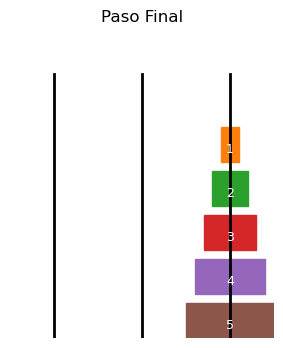

In [29]:
simulate_movements('sequence_dfs', 'initial_state_dfs')

# Ejecución/Simulación STAR A*

In [30]:
# Ejecutar el algoritmo
node, metrics, goal_node = astar_search(5)  # Usamos 5 discos


### Crear archivo `sequence_star_a.json` con los movimientos realizados

In [31]:
#Crear sequence_star_a
save_sequence('sequence_star_a')


In [32]:
#Crear initial_state_star_a
save_initial_state('initial_state_star_a')


### Simulación de los movimientos realizados por STAR A*

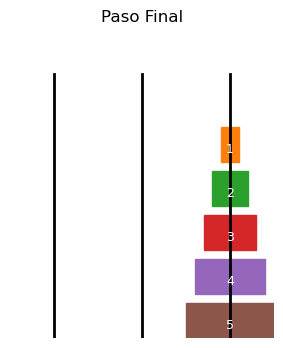

In [33]:
simulate_movements('sequence_star_a', 'initial_state_star_a')


# Ejecución/Simulación Greedy Search


In [34]:
#ejecutar el algoritmo
node, metrics, goal_node = greedy_search(5)


### Crear archivo `sequence_greedy.json` con los movimientos realizados

In [35]:
save_sequence('sequence_greedy')


### Crear archivo `initial_state_greedy.json` con el estado inicial

In [36]:
#crear el archivo initial_state_greedy
save_initial_state('initial_state_greedy')


### Simulación de los movimientos realizados por Greedy Search

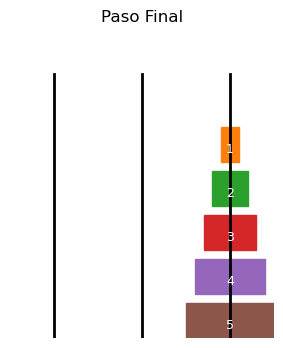

In [37]:
simulate_movements('sequence_greedy','initial_state_greedy')


# Ejecución Dijkstra

In [38]:
#ejecutar el algoritmo
node, metrics, goal_node = dijkstra_search(5)

### Crear archivo `sequence_dijkstra.json` con los movimientos realizados

In [39]:
save_sequence('sequence_dijkstra')

### Crear archivo `initial_state_dijkstra.json` con el estado inicial

In [40]:
save_initial_state('initial_state_dijkstra')

### Simulación de los movimientos realizados por Dijkstra Search

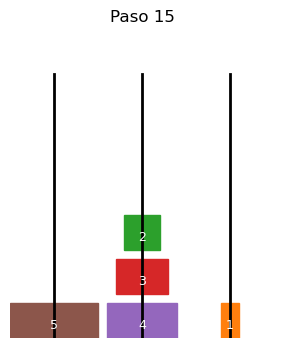

In [ ]:
simulate_movements('sequence_dijkstra','initial_state_dijkstra')

# Preguntas teóricas


## 1. ¿Cuáles son los PEAS de este problema?

- **Performance (desempeño):**
  - Alcanzar el estado objetivo (todos los discos apilados en orden decreciente en la varilla derecha).
  - Minimizar la cantidad de movimientos, ya que esta es proporcional al tiempo de ejecución, dado que el costo de mover cada disco es único y constante para todos.
  - (Opcional) Minimizar el uso de memoria.
- **Environment (entorno):**
  - 5 discos de distinto tamaño están inicialmente apilados en orden decreciente sobre la varilla izquierda, donde en ningun momento un disco puede estar colocado sobre otro de menor tamaño.
  - 3 varillas.
- **Actuators (actuadores):**
  - Mecanismo para mover discos: la única acción posible es trasladar el disco superior de una varilla a otra, especificando la varilla origen y la de destino.
- **Sensores (sensores):**
  - Lectura del estado actual de las varillas: acción de consultar en todo momento qué discos hay en cada varilla y en qué orden.

## 2. ¿Cuáles son las propiedades del entorno de trabajo?

Las propiedades del entorno de trabajo en el contexto de la Torre de Hanoi son:
- **Discreto:** el entorno tiene un número finito y contable de estados posibles. Cada acción cambia el estado de forma puntual y no existen transiciones continuas.
- **Totalmente observable:** se conoce en todo momento la posición exacta de cada disco en cada varilla. No hay información oculta.
- **Determinista:** cada acción tiene un resultado único y predecible. Mover un disco siempre produce el mismo cambio en el estado.
- **Estático:** el entorno no cambia por sí solo. Solo se modifica cuando el agente realiza una acción.
- **Secuencial:** la solución requiere una secuencia ordenada de movimientos donde cada acción depende de las anteriores para alcanzar el objetivo.
- **Agente individual:** hay un único agente encargado de realizar todos los movimientos de los discos. No hay interacción con otros agentes.

## 3. Defina los siguientes conceptos: Estado, Espacio de estados, Árbol de búsqueda, Nodo de búsqueda, Objetivo, Acción, Frontera

- **Estado:** representa una configuración específica de los discos en las tres varillas en un momento dado.
- **Espacio de estados:** es el conjunto de todos los estados posibles que se pueden alcanzar desde el estado inicial, aplicando las reglas del problema, es decir, mover un disco a la vez sin colocar un disco sobre uno de menor tamaño.
- **Árbol de búsqueda:** representa todas las posibles secuencias de movimientos desde el estado inicial hasta el estado objetivo. Es decir, todas las secuencias posibles para pasar de tener los discos apilados en orden decreciente en la varilla izquierda a tenerlos en ese mismo orden en la varilla derecha.
- **Nodo de búsqueda:** representa una configuración de los discos junto con el movimiento que se realizó para llegar a ella. Cada nodo guarda su estado anterior, lo que permite reconstruir la secuencia completa de movimientos desde el inicio.
- **Objetivo:** lograr que todos los discos se encuentren apilados en orden de tamaño decreciente en la varilla derecha.
- **Acción:** mover un único disco superior de una varilla a otra, sin colocarlo encima de un disco más pequeño que él.
- **Frontera:** conjunto de configuraciones de discos generadas por movimientos válidos desde estados anteriores, pero que aún no fueron exploradas para seguir generando nuevos movimientos. Es decir, son los próximos posibles movimientos a considerar en la búsqueda de la solución.

## 4. Implementación del algoritmo

Para la resolución del problema de la Torre de Hanoi se desarrollaron e implementaron los algoritmos de búsqueda Depth-First Search (DFS), Greedy, A* y Dijkstra. En el caso de los algoritmos Greedy y A*, se diseñaron y evaluaron cuatro funciones heurísticas diferentes. Las implementaciones de cada uno de estos algoritmos fueron detalladas previamente en este notebook.

## 5. ¿Cuál es la complejidad teórica en tiempo y memoria del algoritmo elegido?

A continuación se detalla la complejidad temporal y espacial de los algoritmos implementados. Es importante mencionar que, para este análisis:
- 𝑏 representa el factor de ramificación (cantidad de movimientos posibles por estado).
- 𝑚 es la profundidad máxima del árbol de búsqueda.
- 𝑑 es la profundidad de la solución más cercana.
- V Número de vértices (nodos) en el grafo.
- E Número de aristas (conexiones) en el grafo.

| Algoritmo | Complejidad temporal | Complejidad espacial |
|-----------|----------------------|----------------------|
| DFS       | $O(𝑏^𝑚)$ | $O(𝑏.𝑑)$ |
| Greedy    | $O(𝑏^𝑚)$ | $O(𝑏^𝑚)$ |
| A*        | $O(𝑏^𝑑)$ | $O(𝑏^𝑑)$ |
| Dijkstra  | $O(E+VlogV)$ | $O(V)$ |

- **DFS (Depth-First Search):**  
  - **Complejidad temporal:** en el peor caso, explora todo el árbol hasta la profundidad máxima \(m\).  
  - **Complejidad espacial:** guarda únicamente el camino actual en la pila de exploración, cuya profundidad máxima es \(d\). En cada nivel pueden generarse hasta \(b\) nodos sucesores, por lo que la complejidad espacial en el peor caso es \(O(b . d)\).

- **Greedy:**  
  - **Complejidad temporal:** puede expandir casi todo el espacio de búsqueda si la heurística es mala (peor caso), es decir, hasta profundidad \(m\).  
  - **Complejidad espacial:** debe almacenar todos los nodos en la frontera más los explorados, por lo que la complejidad espacial es \(O(b^m)\).

- **A\*:**  
  - **Complejidad temporal:** en el peor caso, si la heurística es muy poco informativa (casi nula), la complejidad es \(O(b^d)\).  
  - **Complejidad espacial:** mantiene en memoria todos los nodos visitados y la frontera, por lo que la complejidad espacial también es \(O(b^d)\).

- **Dijkstra:**  
  - **Complejidad temporal:** depende de la estructura de la cola de prioridad; usando un min-heap, que es la implementación más común, es \(O(E + V \log V)\). En el peor caso, se exploran todos los vértices y aristas del grafo.  
  - **Complejidad espacial:** requiere almacenar la distancia mínima a cada vértice y mantener la cola de prioridad, por lo que la complejidad espacial es \(O(V)\), siendo \(V\) el número de nodos.


Estas complejidades corresponden al peor caso. Sin embargo, los algoritmos de búsqueda informada como Greedy y A* pueden ser significativamente más eficientes en la práctica si la heurística utilizada es adecuada. Una heurística se considera buena si es admisible (nunca sobreestima el costo real al objetivo) y, en el caso de A*, también consistente (cumple con la desigualdad triangular).

## 6. A nivel de implementación, ¿cuánto tiempo y memoria utiliza el algoritmo?

A continuación se presenta una tabla en la que se comparan el tiempo de ejecución y el uso de memoria de cada algoritmo. Los datos fueron extraídos de la tabla comparativa mostrada previamente en este notebook.

| Algorithm      | Time [ms] | Memory [MB] |
|----------------|-----------|--------------|
| Breadth-first  | 272.42    | 1.70         |
| Depth-first    | 22.24     | 0.24         |
| Greedy 1       | 61.98     | 0.25         |
| Greedy 2       | 39.42     | 0.24         |
| Greedy 3       | 32.88     | 0.21         |
| Greedy 4       | 37.65     | 0.35         |
| A* 1           | 63.22     | 0.22         |
| A* 2           | 53.03     | 0.21         |
| A* 3           | 52.72     | 0.20         |
| A* 4           | 64.40     | 0.27         |
| Dijkstra       | 77.82     | 0.32         |

A partir de la tabla se puede observar cómo la modificación de la heurística utilizada impacta significativamente en el rendimiento de los algoritmos Greedy y A*. En particular, la heurística 4 es una versión alterada de la heurística 3 que arroja valores incorrectos, lo que genera una caída en el rendimiento (ver caso Greedy 4). No obstante, A* logra mitigar en gran medida los efectos negativos de una heurística deficiente, manteniendo un desempeño estable incluso con una función heurística no ideal.

## 7 ¿Qué tan lejos está la solución encontrada por el algoritmo implementado de esa solución óptima?

La solución óptima para la Torre de Hanoi con 5 discos es 31 movimientos.
A partir de los resultados obtenidos en las ejecuciones, se observa lo siguiente:
- **DFS:** encuentra la solución realizando en promedio 90 movimientos adicionales respecto de la solución óptima.
- **Greedy:** encuentra la solución realizando en promedio 5 movimientos adicionales. Sin embargo, esto depende de la heurística utilizada, por ejemplo, en el caso de la solución "Greedy 3", se obtiene la solución óptima.
- **A\*:** encuentra la solución utilizando exactamente 31 movimientos, es decir, logra la solución óptima.
- **Dijkstra:** encuentra la solucion utilizando 31 movimiento, es decir, logra la solución óptima.